In [1]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

In [4]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.146739,-2.738958,3.672001,4.319488,2.060131,1.106603,2.756807,-1.807586,3.119252,-0.814754,...,2.498754,-1.766720,0.291909,-0.236563,0.366089,-2.615653,2.517367,-2.121267,4.024024,1.430665
1,-3.081997,-4.560731,-0.439482,2.801814,-2.063705,0.320462,2.700044,-1.313459,2.488874,-1.288608,...,3.506879,1.340675,0.644034,0.583566,-1.396967,-2.599615,0.540591,-0.846946,0.476570,1.209218
2,-0.923654,-0.931160,0.270649,0.993372,1.246490,1.068892,0.833382,-0.559276,1.961053,-4.149379,...,5.081479,1.130174,-2.890191,-2.820214,1.395403,-3.846228,-1.152302,-2.224700,1.176310,-0.315757
3,-0.047425,-3.906727,0.635823,0.752494,1.742398,0.973911,0.725889,-0.415176,3.048928,-2.944524,...,3.968297,0.803104,-1.049701,-2.646564,0.847253,-2.600662,-0.752832,0.028893,-0.424166,-1.445955
4,-6.648052,-0.395714,2.429264,2.590817,-0.684888,-1.006098,0.028183,2.124310,1.596855,-2.533973,...,-1.403458,-1.843892,-0.527678,-3.595732,-2.341160,-1.960664,-0.313663,-3.191498,0.681570,-2.437148


In [5]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [6]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [7]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [8]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/upper_bound.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/upper_bound.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/upper_bound.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

In [9]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,bbc.com/news/av/world-asia-44875089/thai-cave-...,cave_rescue
1,indystar.com/story/news/nation-now/2018/07/16/...,cave_rescue
2,washingtonpost.com/world/asia_pacific/these-di...,cave_rescue
3,yahoo.com/news/m/bf445926-e74e-3e41-8ec3-0fc68...,cave_rescue
4,centurylink.net/news/read/article/the_associat...,cave_rescue
...,...,...
713,dailycaller.com/2018/07/19/mike-huckabee-media...,helsinki
714,cnn.com/2018/07/19/politics/atlantic-council-r...,helsinki
715,sfgate.com/news/politics/article/trump-embrace...,helsinki
716,yahoo.com/news/m/78f6000e-d04c-355b-867d-8d5c8...,helsinki


In [10]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [11]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [12]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((185, 10), (176479, 10))

Sample and include all the labeled article

In [13]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [14]:
sample_emb_df = emb_df.loc[sample_df.index]

In [15]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [16]:
admat = nn.kneighbors_graph( mode='connectivity'); admat

<10185x10185 sparse matrix of type '<class 'numpy.float64'>'
	with 101850 stored elements in Compressed Sparse Row format>

In [17]:
G = nx.from_scipy_sparse_matrix(admat)

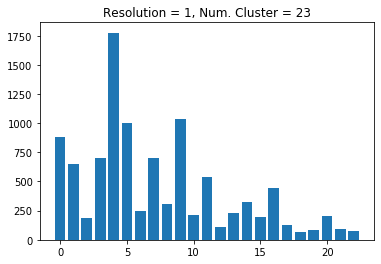

In [18]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [19]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(4, 1776, 249.0)

In [20]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [21]:
pc = clusters# prune_cluster(cluster, 5)

In [22]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

23

In [23]:
len(article_cluster[0].title.tolist())

880

In [24]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [25]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
Thai cave rescue: What we learned as boys tell of or
Sheriff: 8 dead after Missouri tourist boat accident
Trump’s groveling before a dictator takes his awful behavior to a new low
After rescue, soccer boys pray for protection at Thai temple | Newsday
Trump invites Putin to Washington to follow up on Helsinki summit
Sean Spicer: I 'See No Evidence' That Mueller's Probe Is A 'Witch Hunt'
Why  Comments About Montenegro Were a Win for
want suspected covert Russian agent kept in jail
approved announcing Mueller's latest Russia indictment ahead of his meeting with Putin: source
Sheriff: 8 people dead after Missouri tourist boat
-------------------------------------------------- text --------------------------------------------------
Thai cave rescue: What we learned as boys tell of ordeal ### 18 July 2018 ### These are external lin
FacebookEmail Twitter Google+ LinkedIn Pinterest ### S

## Top clusters

In [26]:
cluster_sizes = np.array(list(map(len, article_cluster)))

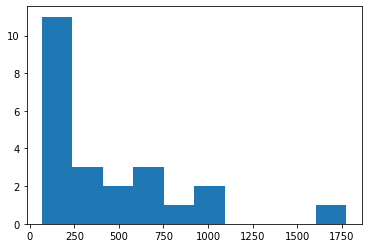

In [27]:
plt.hist(cluster_sizes);

In [28]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1776, 1037,  998,  880,  705,  701,  653,  539,  446,  320,  310,
        249,  229,  211,  202,  199,  184,  123,  106,   91,   81,   76,
         69])

In [29]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
17617,34,bbc.co.uk/programmes/w172w257hgvmgh6,7/19/2018 6:18:17 AM -04:00,Thai Boys Discuss 'Moment of Miracle',BBC World Service ### Newshour ### The twelve ...,1,en,37,586,cave_rescue
17648,34,bbc.co.uk/news/av/world-asia-44875088/thai-cav...,7/19/2018 6:00:43 AM -04:00,Thailand cave rescue: Boy 'shocked' to be foun...,Media playback is unsupported on your device #...,1,en,58,441,cave_rescue
36549,398,newsbusters.org/blogs/nb/pj-gladnick/2018/07/1...,7/19/2018 2:46:40 PM -04:00,CNN Finally Finds Former Trump Supporter Who R...,CNN Finally Finds Former Trump Supporter Who R...,1,en,61,3302,helsinki
41640,36,wsj.com/articles/eight-die-after-boat-capsizes...,7/19/2018 11:51:12 PM -04:00,Eight Die After Boat Capsizes in Storm Near Br...,### Eight Die After Boat Capsizes in Storm Nea...,1,en,63,572,duckboat


In [30]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Thai Boys Discuss 'Moment of Miracle'
Thailand cave rescue: Boy 'shocked' to be found - BBC News
CNN Finally Finds Former Trump Supporter Who Regrets Her Vote
Eight Die After Boat Capsizes in Storm Near Branson, Mo.  - WSJ
‘Mass casualty incident’ reported at Table Rock Lake | FOX2now.com
's 'No' About Russian Interference Requires Yet More Clarification
CBS Poll: Majority disapproves with Trump's Handling of Putin - CNNPolitics
Why Russia Will Help the Democrats Next - POLITICO Magazine
Officials: Allies discount Trump-Putin summit as 'meaningless'


In [31]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

/Users/tniyomkarn/via_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
articles = pd.concat(article_cluster)

In [33]:
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()

In [34]:
HTML(assignments.to_html())

## Evaluate

In [35]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby(['label','assignment']).apply(lambda x: x['label'].count()))
cluster_to_prediction

0
label       assignment    
cave_rescue 0            2
            1            1
            2            2
            3            1
            4            6
            5            3
            7            2
            8            1
            9            5
            10           2
            11           2
            14           2
            16           3
duckboat    0            1
            1            1
            2            1
            4            4
            5            1
            6            1
            7            2
            9            3
            10           1
            11           2
            13           1
            16           1
            17           1
            18           1
helsinki    0           10
            1           17
            2            2
            3           12
            4           30
            5           15
            6            3
            7            9
            8            2
            9            5
            10           1
            11           8
            12           3
            13           1
            14           5
            15           1
            16           4
            17           3
            19           1

In [36]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby("assignment").apply(lambda x: x['label'].mode()))
cluster_to_prediction = cluster_to_prediction.reset_index().groupby('assignment').apply(lambda x: x.sample(1)).reset_index(drop = True)[['assignment', 0]]

In [37]:
cluster_to_prediction.columns = ['assignment', 'prediction']
cluster_to_prediction

,assignment,prediction
0,0,helsinki
1,1,helsinki
2,2,helsinki
3,3,helsinki
4,4,helsinki
5,5,helsinki
6,6,helsinki
7,7,helsinki
8,8,helsinki
9,9,cave_rescue


In [38]:
articles = articles.merge(cluster_to_prediction, on=('assignment'))
articles['label'].fillna('unlabeled', inplace=True)
articles.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/skripal-poisonin...,7/19/2018 11:16:00 AM -04:00,"Skripal Poisoning Suspects 'Identified': ""[We'...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,71,3105,helsinki,0,helsinki
1,3,foxnews.com/us/2018/07/19/duck-boat-capsizes-o...,7/20/2018 12:24:52 AM -04:00,Duck boat capsizes on Missouri lake; multiple ...,Duck boat capsizes on Missouri lake; multiple ...,1,en,76,2575,duckboat,0,helsinki
2,6,yahoo.com/news/m/5aed6cdf-0e14-303c-9415-1d70f...,7/19/2018 5:44:03 AM -04:00,Elon Musk apologizes to British cave diver fol...,Elon Musk apologizes to British cave diver fol...,1,en,78,885,cave_rescue,0,helsinki
3,6,yahoo.com/news/m/fc313a48-6f01-339c-8304-69704...,7/19/2018 5:13:35 AM -04:00,"with Cabinet, has little to say about","President Trump meets with Cabinet, has little...",1,en,37,890,helsinki,0,helsinki
4,6,yahoo.com/news/votel-no-direction-syria-trump-...,7/19/2018 10:07:55 PM -04:00,Votel: No new direction on Syria after Trump-P...,Votel: No new direction on Syria after Trump-P...,1,en,56,2160,helsinki,0,helsinki


[[ 125    1    6    0]
 [  15    2    4    0]
 [  25    0    7    0]
 [8105  295 1231    0]]


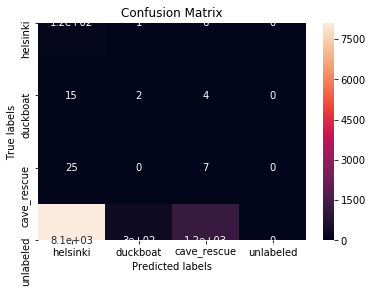

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

labels = articles['label'].unique()
cm = confusion_matrix(list(articles['label']), list(articles['prediction']), labels)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = sns.heatmap(cm, annot=True, ax = ax);
plt.title('Confusion matrix of the classifier')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [40]:
cm_without_unlabeled = cm[:-1, :-1]
acc = np.trace(cm_without_unlabeled)/np.sum(cm_without_unlabeled)
print("Accuracy: ", acc)

Accuracy:  0.7243243243243244


In [41]:
cm_without_unlabeled

array([[125,   1,   6],
       [ 15,   2,   4],
       [ 25,   0,   7]])

In [42]:
labeled_articles = articles.dropna(subset=['label'])
concat_labeled_articles = list(labeled_articles[['text','prediction']].groupby(['prediction'])['text'].apply(lambda x: ' '.join(x)))
# df[['name','text','month']].drop_duplicates()

## Tf-idf using 2 groups

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(concat_labeled_articles)

In [44]:
vectors.todense()

matrix([[2.96248838e-03, 8.30739748e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.96205915e-03, 5.23215774e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.75202144e-03, 8.16075620e-03, 5.04283261e-06, ...,
         5.04283261e-06, 1.00856652e-05, 5.04283261e-06]])

In [45]:
tfidfs = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())

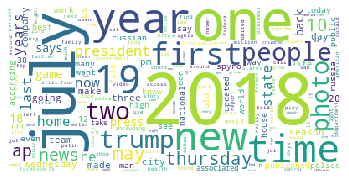

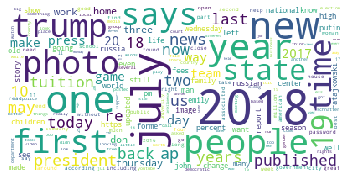

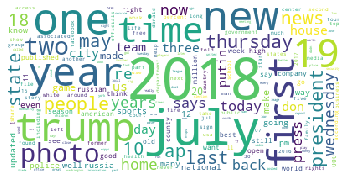

In [46]:
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
stopwords.update(["said", "will"])
for i in range(0, len(tfidfs)):
    d = {}
    for k,v in tfidfs.T[i].reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
            
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords)
    wc = wordcloud.fit_words(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Averaged tf-idf among each group

In [47]:
def avg_tfidf(clustered_articles):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(clustered_articles)
    return np.mean(vectors, axis = 0), vectorizer

In [48]:
avg_tfidf(labeled_articles[labeled_articles['prediction'] == 'helsinki']['text'])

(matrix([[3.30674035e-03, 5.32615546e-03, 1.99068036e-05, ...,
          6.27849393e-06, 1.89581381e-06, 4.44888395e-06]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

In [49]:
averaged_tfidfs = labeled_articles[['text','prediction']].groupby(['prediction'])['text'].agg(avg_tfidf)

In [50]:
averaged_tfidfs[1]

(matrix([[5.37518970e-03, 3.41512655e-03, 3.66702499e-05, ...,
          9.31105856e-05, 9.31105856e-05, 9.31105856e-05]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

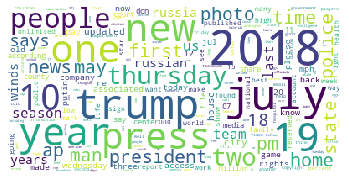

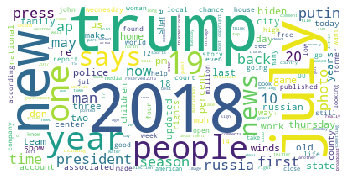

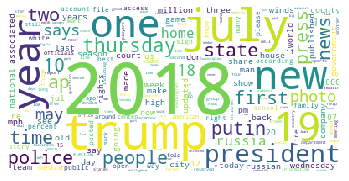

In [51]:
for i in range(0, len(averaged_tfidfs)):
    tf, vec = averaged_tfidfs[i]
    wordcloud = WordCloud(background_color = 'white')
    tfidfs = pd.DataFrame(tf, columns=vec.get_feature_names())
    d = {}
    for k,v in tfidfs.T.reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
    wc = wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Naming clusters

### Assume perfect clustering algorithm

In [52]:
helsinki = articles[articles['label'] == 'helsinki']

In [53]:
helsinki

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/skripal-poisonin...,7/19/2018 11:16:00 AM -04:00,"Skripal Poisoning Suspects 'Identified': ""[We'...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,71,3105,helsinki,0,helsinki
3,6,yahoo.com/news/m/fc313a48-6f01-339c-8304-69704...,7/19/2018 5:13:35 AM -04:00,"with Cabinet, has little to say about","President Trump meets with Cabinet, has little...",1,en,37,890,helsinki,0,helsinki
4,6,yahoo.com/news/votel-no-direction-syria-trump-...,7/19/2018 10:07:55 PM -04:00,Votel: No new direction on Syria after Trump-P...,Votel: No new direction on Syria after Trump-P...,1,en,56,2160,helsinki,0,helsinki
5,148,cleveland.com/letters/index.ssf/2018/07/is_don...,7/19/2018 5:36:04 AM -04:00,Is Donald Trump a Russian agent,Enter City and State or Zip Code ### Congratul...,1,en,31,417,helsinki,0,helsinki
6,44,dailymail.co.uk/news/article-5971475/flake-sug...,7/19/2018 2:46:51 PM -04:00,Flake suggests TREASON on the Senate floor say...,Share this article ### Share ### Flaked and De...,1,en,111,1906,helsinki,0,helsinki
...,...,...,...,...,...,...,...,...,...,...,...,...
9103,76,chron.com/news/media/chyno-miranda-nos-habla-d...,7/19/2018 5:52:51 AM -04:00,Chyno Miranda nos habla de su nuevo sencillo ‘...,Chyno Miranda nos habla de su nuevo sencillo ‘...,1,en,67,885,helsinki,16,helsinki
9543,6,yahoo.com/news/us-intelligence-chief-tough-rus...,7/20/2018 6:20:39 AM -04:00,Even US intel chief in the dark about Trump-Pu...,Even US intel chief in the dark about Trump-Pu...,1,en,55,5743,helsinki,17,helsinki
9545,44,dailymail.co.uk/wires/ap/article-5969139/new-m...,7/19/2018 6:28:47 AM -04:00,New Mexico to eliminate 4 sports to curb spend...,"Thursday, Jul 19th 2018 5-Day Forecast ### Adv...",1,en,69,3611,helsinki,17,helsinki
9546,94,chicagotribune.com/news/opinion/letters/ct-let...,7/19/2018 6:02:47 AM -04:00,What the media missed in the Trump-Putin meeti...,Letter: ### What the media missed in the Trump...,1,en,66,1303,helsinki,17,helsinki


In [54]:
import spacy
#get the noun, verb, word entity for each articles
nlp = spacy.load("en_core_web_sm")
noun_phrases_list = []
verb_phrases_list = []
entites_list = []
for text in helsinki['text']:
    doc = nlp(text)
    noun_phrases_list.append([chunk.text for chunk in doc.noun_chunks])
    verb_phrases_list.append([token.lemma_ for token in doc if token.pos_ == "VERB"])
    entites_list.append([entity.text for entity in doc.ents])

In [55]:
len(entites_list)

132

In [56]:
sum(np.array(entites_list) == 'Helsinki')

0

In [57]:
import re

cleaned_entity_list = [[re.sub('[^0-9a-zA-Z ]+', '', ent).strip() for ent in entites] for entites in entites_list]
cleaned_entity_list = [[ce for ce in cleaned_entities if ce != ''] for cleaned_entities in cleaned_entity_list]

In [58]:
N = len(cleaned_entity_list)

In [59]:
wordSet = set().union(*[set(lis) for lis in cleaned_entity_list])

In [60]:
wordDicts = [dict.fromkeys(wordSet, 0)] * len(cleaned_entity_list)


In [61]:
wordDF = pd.DataFrame(wordDicts)

In [62]:
for idx, art in enumerate(cleaned_entity_list):
    for word in art:
        wordDF.iloc[idx][word]+=1

In [63]:
import math
idf = np.log10(N/np.sum(wordDF))

In [64]:
topic_tfidf = wordDF*idf

In [65]:
np.mean(topic_tfidf['Helsinki'])

-0.16658498214439993

In [66]:
# Expect to see 'Helsinki' somewhere on top
top_n = 40
top_n_keywords = np.mean(topic_tfidf).sort_values(ascending=False)[:top_n]
top_n_keywords

Congress          0.159761
AP                0.159376
Americans         0.159328
Coats             0.159328
Democratic        0.159040
today             0.158801
America           0.158421
Montenegro        0.157723
House             0.157723
White House       0.157723
Moscow            0.154923
Kremlin           0.154832
Syria             0.154832
two               0.154146
CNN               0.153892
second            0.153892
Tuesday           0.153316
Finland           0.152861
China             0.152861
July 19 2018      0.151737
Russians          0.151500
Ukraine           0.150515
FBI               0.150515
12                0.147770
Republican        0.147265
first             0.146086
WASHINGTON        0.144599
GOP               0.144599
More              0.140975
Dan Coats         0.138982
2018              0.136862
this week         0.136862
State             0.136862
Cuomo             0.136862
North Korea       0.134611
Pompeo            0.134611
morevert          0.134611
E